# Итоговая работа "Анализ данных временных рядов. Модель ARIMA"

In [127]:

from ticers import Ticers
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

t = Ticers()
t.dowload_data('GAZP', '2020-01-01', '2022-12-13')
p = pd.read_csv('./data/company/GAZP.csv')

# Индексируем поле Data
p.set_index('Date', inplace=True)

# Переводим текстоый формат в datetime для удобного проведения срезов
p.index = pd.to_datetime(p.index)
p

[*********************100%***********************]  1 of 1 completed


,GAZP
Date,
2020-01-03,228.495285
2020-01-06,226.333832
2020-01-08,225.663345
2020-01-09,224.145935
2020-01-10,222.231506
...,...
2022-05-18,264.839996
2022-05-19,266.679993
2022-05-20,266.679993


# Нахождение скользящего среднего

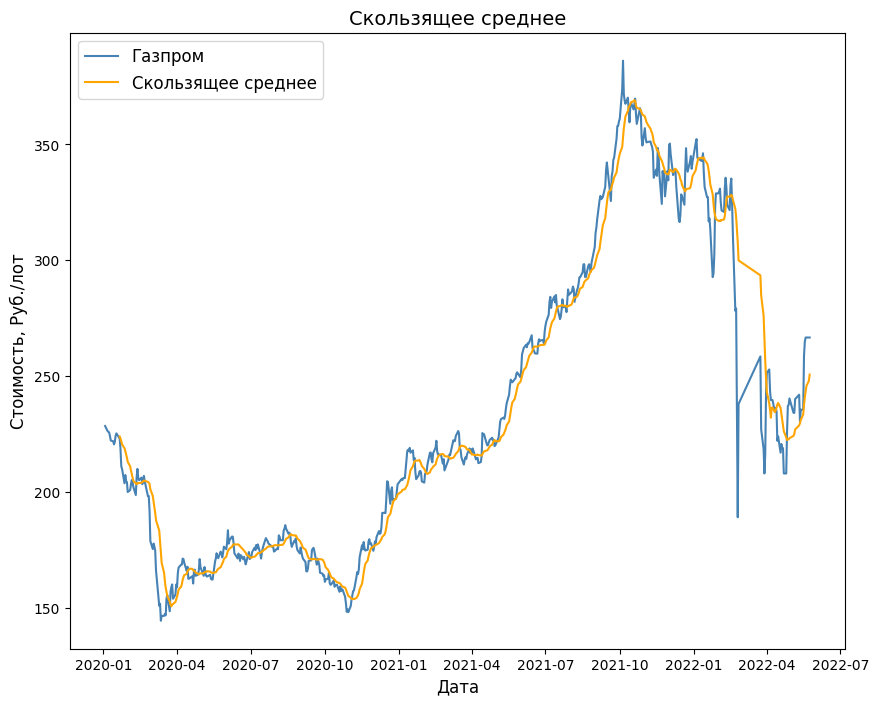

In [128]:
plt.figure(figsize = (10,8))
plt.plot(p, label = 'Газпром', color = 'steelblue')

# window - наблудение через кажные 12 дней
plt.plot(p.rolling(window = 12).mean(), label = 'Скользящее среднее', color = 'orange')

plt.legend(title = '', loc = 'upper left', fontsize = 12)

# добавим подписи к осям и заголовки
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Стоимость, Руб./лот', fontsize = 12)
plt.title('Скользящее среднее', fontsize = 14)

plt.show()

# Тест Харки-Бера. Определение нормальности распределения

In [129]:
import numpy as np
from statsmodels.iolib.table import SimpleTable

row = [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(p['GAZP'])
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB               p-value                skew             kurtosis    
-----------------------------------------------------------------------------
57.52858712636123 3.2197787491194166e-13 0.6195974641979118 2.085282119652063
-----------------------------------------------------------------------------


Вывод: JB=~57>>0, распределение ошибок близко к нормальному

#  Тест Дикки-Фуллера. Определение стационарности ряда

In [130]:
adf_test = adfuller(p['GAZP'])
print('adf: ', adf_test[0])
print('p-value: ', adf_test[1])
print('Critical values: ', adf_test[4])
if adf_test[0]> adf_test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

# p-value = 0.70773344776174 // p > 0,05 значит ряд НЕСТАЦИОНАРНЫЙ, сезонности нет
# Следовательно, подходит модель ARIMA / ARIMAX

adf:  -1.1182647528389473
p-value:  0.7077334455512994
Critical values:  {'1%': -3.441935806025943, '5%': -2.8666509204896093, '10%': -2.5694919649816947}
есть единичные корни, ряд не стационарен


# Расширенный тест Дикки-Фуллера. Определение порядка интегрирования (d)

In [131]:
pdiff = p['GAZP'].diff(periods=1).dropna()

test = sm.tsa.adfuller(pdiff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -5.95186994204808
p-value:  2.1377358896022318e-07
Critical values:  {'1%': -3.441935806025943, '5%': -2.8666509204896093, '10%': -2.5694919649816947}
единичных корней нет, ряд стационарен


Вывод: ряд стационарен при 'periods=1', Порядок интегрирования 1

# Поиск тренда

<AxesSubplot: xlabel='Date'>

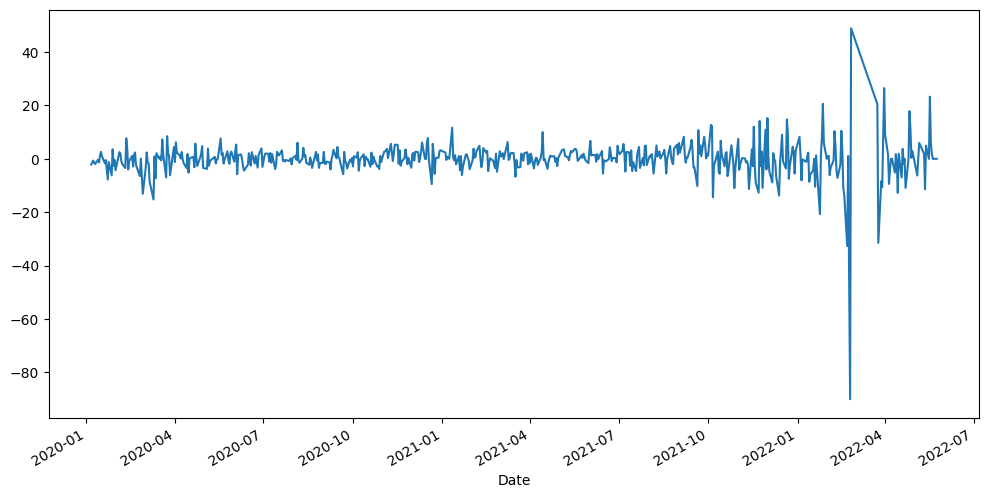

In [132]:
pdiff.plot(figsize=(12,6))

Вывод: Судя по графику ярко выроженный тренд отсутствует

# Автокорреляция. Поиск порядока компонетны MA (q) и AR (p)

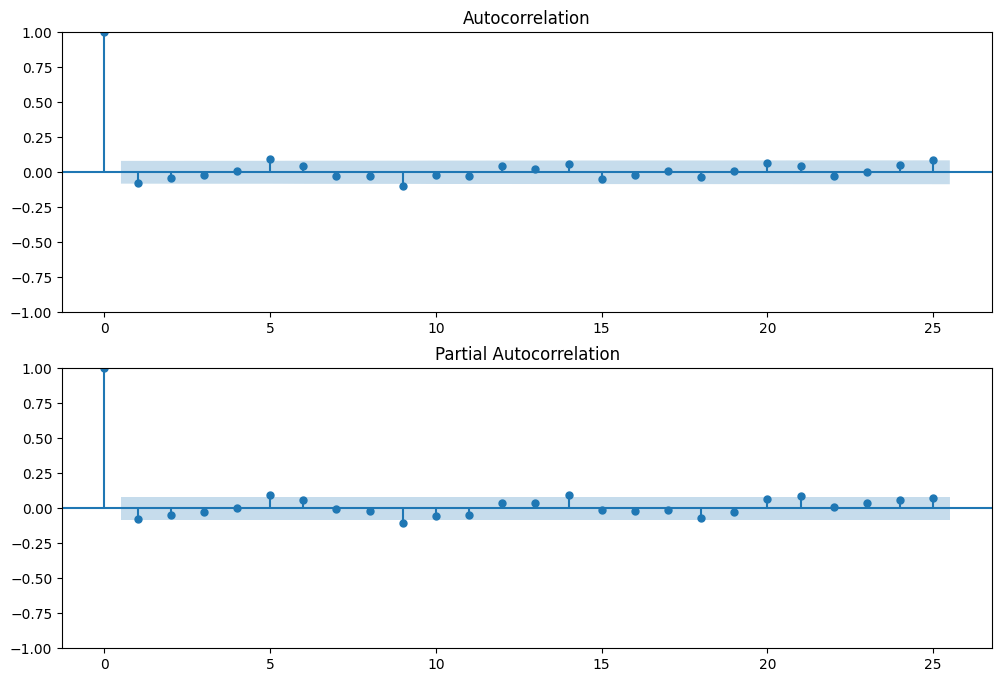

In [133]:
# импортируем функцию для построения автокорреляционной функции (ACF)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pdiff.values.squeeze(), lags=25, ax=ax1) # MA(q)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pdiff, lags=25, ax=ax2) # AR(p)

Вывод: q и p = 1, т.к. обе диаграммы имеют по 1 ярко выраженному лагу

# Построение прогноза

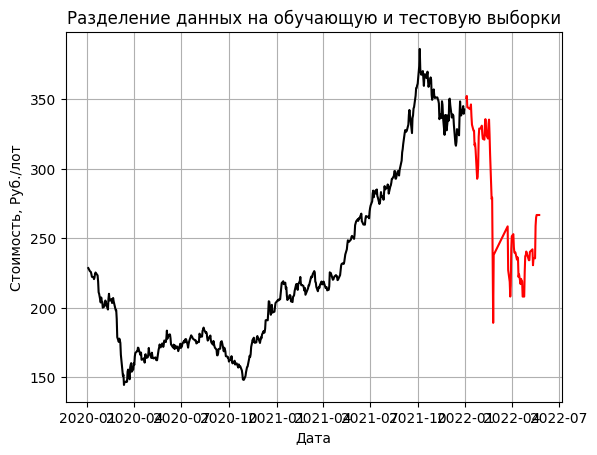

In [134]:
# Разбиваем данные на обучаущую и тестовую выборки

train = p[:'2022-01-01']
test = p['2022-01-02':]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Стоимость, Руб./лот')
plt.xlabel('Дата')

plt.grid()
plt.show()

# Обучение

In [135]:
# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

a_model = sm.tsa.ARIMA(train, order=(1,1,1))
model = a_model.fit()
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                   GAZP   No. Observations:                  504
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1397.737
Date:                Wed, 14 Dec 2022   AIC                           2801.473
Time:                        05:38:51   BIC                           2814.135
Sample:                             0   HQIC                          2806.441
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9881      0.014     69.772      0.000       0.960       1.016
ma.L1         -0.9757      0.019    -50.268      0.000      -1.014      -0.938
sigma2        15.1720      0.629     24.121      0.0

# Тест Льюнга-Бокса. Соответсвие "белому шуму"

In [136]:
from pandas import DataFrame

#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) 
print (DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

      Q-stat   p-value
0   0.023857  0.877249
1   0.109521  0.946712
2   0.287509  0.962360
3   0.434079  0.979593
4   0.435805  0.994286
5   0.441678  0.998478
6   0.456384  0.999591
7   0.487614  0.999879
8   0.489036  0.999972
9   0.489036  0.999994
10  0.501821  0.999999
11  0.757097  0.999997
12  1.583809  0.999941
13  1.597163  0.999979
14  1.615771  0.999993
15  1.904972  0.999993
16  2.075817  0.999995
17  2.236355  0.999997
18  2.357521  0.999999
19  2.485145  0.999999
20  2.681099  0.999999
21  2.683610  1.000000
22  2.716679  1.000000
23  2.726366  1.000000
24  2.744842  1.000000
25  3.175046  1.000000
26  3.208778  1.000000


Вывод: нельзя отвергнуть нулевую гипотезу теста, значения данных независимы. "Белого шума" вероятно нет

# Коэффициент детерминации

In [137]:
from sklearn.metrics import r2_score


pred = model.predict()

#r2 = r2_score(p, pred[1:32])
#print ('R^2: %1.2f' % r2)
pred

Date
2020-01-03      0.000000
2020-01-06    228.495351
2020-01-08    226.293298
2020-01-09    225.611677
2020-01-10    224.068323
                 ...    
2021-12-24    341.011056
2021-12-27    338.315525
2021-12-28    342.900253
2021-12-29    345.144933
2021-12-30    339.562894
Name: predicted_mean, Length: 504, dtype: float64

# Среднеквадратичное отклонение

In [138]:
import ml_metrics as metrics

metrics.rmse(train,pred[1:32])

67.40005131779307

# Средняя абсолютная ошибка

In [139]:
metrics.mae(train,pred[1:32])

52.220065740595444

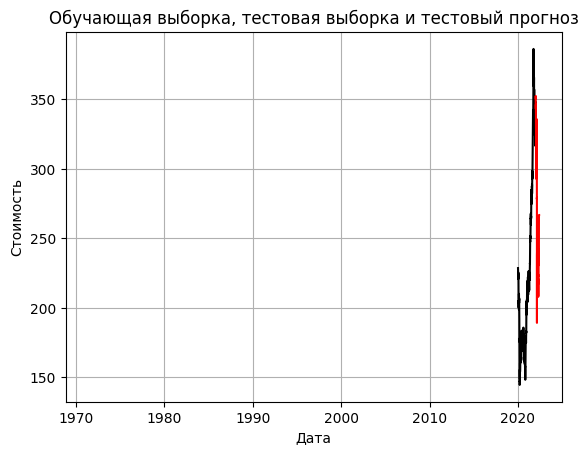

In [166]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1

predictions = model.predict(start, end)

# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)

plt.plot(train, 'black')
plt.plot(test, 'r')
plt.plot(predictions, 'g--')
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Стоимость')
plt.xlabel('Дата')
 
# добавим сетку
plt.grid()
plt.show()



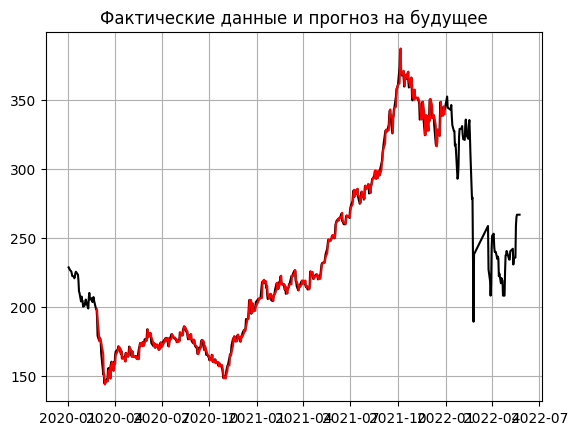

In [141]:
# прогнозный период с конца имеющихся данных
start = len(p)
 
# и закончится 36 месяцев спустя
end = (len(p) - 1) + 3 * 12
 
# теперь построим прогноз на три года вперед
forecast = model.predict(3*12)
 
# посмотрим на весь 1963 год
forecast[-12:]

# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(p, color = 'black')
plt.plot(forecast, 'r')
 
# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
 
# добавим сетку
plt.grid()
 
plt.show()